Latest

# MNIST CNN Classifier
Adapted from the [mnist_cnn keras example](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py) pointed to from the [AWS tutorial on containers](https://aws.amazon.com/getting-started/tutorials/train-deep-learning-model-aws-ec2-containers/):
```
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
```

Further adapted from Yan LeCunn's top performing MNIST paper:
[Regularization of Neural Networks using DropConnect](http://yann.lecun.com/exdb/publis/pdf/wan-icml-13.pdf)

https://github.com/j05t/mnist

# Setup libraries and parameters

In [0]:
import time
import pickle
import imageio
import os.path
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
#from torch.autograd import Variable

In [0]:
# For confusion matrix and 2D embedding
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

In [0]:
import PIL
import itertools

In [5]:
try:
    # Run this cell to mount your Google Drive.
    data_path = '/content/drive'
    from google.colab import drive
    drive.mount(data_path)
    data_path = os.path.join(data_path, 'My Drive')
except:
    # Just write locally if not in Colaboratory
    data_path = '.'

data_path = os.path.join(data_path, 'checkpoints')
try:
    !mkdir -p "$data_path"
except:
    print('Couldn\'t create', data_path)

print(data_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/checkpoints


In [0]:
!mkdir -p "$data_path"

In [0]:
# Control the resolution of figures plotted below. 200 dpi works well on my macbook
plt.rcParams['figure.dpi'] = 200

# Network definition
Adapted from this portion of the Keras example model
```
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
```
A few modifications:
* I changed the first layer to output 8 channels instead of 32, with the rationale being that a 3x3 kernel only spans 9 DOF. Any channels above 9 would start to become linearly dependent, but the nonlinearity after them might allow them to learn more?
* I added batch normalization after the first two convolutional layers because...well...everyone says they are helpful

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, 1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3, 1)
        self.bn4 = nn.BatchNorm1d(1024)
        self.fc1 = nn.Linear(4*4*64, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.drop1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 10)

    # Output fc1 features
    def features(self, x):
        # input: 28 x 28 x 1
        cl1 = self.bn1(F.leaky_relu(self.conv1(x), negative_slope=0.3))
        # layer1: 26 x 26 x 32
        cl2 = self.bn2(F.max_pool2d(F.leaky_relu(self.conv2(cl1), negative_slope=0.3),2,2))
        # layer2: 12 x 12 x 32
        cl3 = self.bn3(F.leaky_relu(self.conv3(cl2), negative_slope=0.3))
        # layer3: 10 x 10 x 64
        cl4 = F.max_pool2d(F.leaky_relu(self.conv4(cl3), negative_slope=0.3),2,2)
        # layer4: 4 x 4 x 64 -> 1024
        fc1 = self.bn5(F.leaky_relu(self.fc1(self.bn4(cl4.view(-1, 4*4*64))), negative_slope=0.3))
        # layer5: 512
        return fc1
    
    def forward(self, x):
        fc1 = self.features(x)
        # layer size 1x512
        fc2 = self.fc2(self.drop1(fc1))
        # layer size 1x10
        return F.log_softmax(fc2, dim=1)

    def print_size(self):
        total_model_size = 0
        print("Model's state_dict:")
        # print out size of each set of parameter
        for param_tensor in self.state_dict():
            sz = self.state_dict()[param_tensor].size()

            # skip empty parameters (like batch normalization history length)
            if len(sz) == 0:
                continue

            total_model_size += np.prod(sz)
            if len(sz) > 1:
                print('{:16s} {:26s} : {} x {} = {:,}'.format(param_tensor, str(sz), sz[0], np.prod(sz[1:]), np.prod(sz)))
            else:
                print('{:16s} {:26s} : {:,}'.format(param_tensor, str(sz), np.prod(sz)))

        # print out total
        print('\n{:43} : {:,}'.format('Total Model Size',total_model_size))

In [0]:
class Optimizer:
    def __init__(self,
                 seed=1,
                 no_cuda=False,
                 #load_checkpoint=12,
                 load_checkpoint=False,
                 checkpoint_path='.',
                 checkpoint_prefix='mnist_'):

        self.batch_size=512
        self.test_batch_size=1000
        
        torch.manual_seed(seed)
        self.epoch = 0
        
        use_cuda = not no_cuda and torch.cuda.is_available()
        self.kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
        self.device = torch.device("cuda" if use_cuda else "cpu")
        self.model = Net().to(self.device)
        
        #self.lr=0.01
        #self.momentum=0.5
        #self.optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=self.momentum)
        #self.optimizer = optim.Adadelta(self.model.parameters(), lr=self.lr)
        self.optimizer = optim.Adam(self.model.parameters())
        self.loss_criterion = nn.CrossEntropyLoss(reduction='sum')

        self.checkpoint_path = checkpoint_path
        self.checkpoint_prefix = checkpoint_prefix
        self.save_checkpoints = True
        self.checkpoint_interval = 1

        # reset stats file
        if self.save_checkpoints:
            fn = os.path.join(self.checkpoint_path, '{}stats.pkl'.format(self.checkpoint_prefix))
            if os.path.exists(fn):
                os.remove(fn)
            
        if load_checkpoint:
            self.load_checkpoint(load_checkpoint)
            self.test(test_loader)

    def set_learning_rate(self, lr):
        self.optimizer = optim.Adam(self.model.parameters(), lr)
        
    def train(self, train_loader):
        # Set model to be in training mode
        self.model.train()
        
        # Accuracy accumulator 
        correct = 0
        total_loss = 0
        mini_batch_losses = []
        for data, target in train_loader:
            data, target = data.to(self.device), target.to(self.device)
            self.optimizer.zero_grad()
            output = self.model(data)

            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            loss = self.loss_criterion(output, target)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
            mini_batch_losses.append(loss.item()/len(data))

        return total_loss, correct, mini_batch_losses
        
    def test(self, test_loader):
        # Set model to be in testing mode
        self.model.eval()

        # Accuracy accumulator 
        correct = 0
        total_loss = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)

                pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()

                total_loss += self.loss_criterion(output, target).item() # sum up batch loss

        return total_loss, correct

    def run_epoch(self, train_loader, test_loader):
        train_start = time.perf_counter()
        train_loss, train_correct, mini_batch_losses = self.train(train_loader)
        train_end = time.perf_counter()
        train_count = len(train_loader.dataset)
        train_delta = train_end - train_start

        test_start = time.perf_counter()
        test_loss, test_correct = self.test(test_loader)
        test_end = time.perf_counter()
        test_count = len(test_loader.dataset)
        test_delta = test_end - test_start

        print('{:5d} | {:5.1f}s, {:4.1f}s | {:6.4f}, {:6.4f} | {:5d}/{:5d} ({:.2f}%), {:4d}/{:4d} ({:5.2f}%)'.format(
            self.epoch,
            train_delta, test_delta,
            train_loss/train_count, test_loss/test_count,
            train_correct, train_count, 100. * train_correct / train_count,
            test_correct, test_count, 100. * test_correct / test_count))
        
        self.epoch = self.epoch + 1
        
        if self.save_checkpoints:
            stats = {'losses' : mini_batch_losses,
                     'train_loss' : train_loss,
                     'train_count' : train_count,
                     'train_correct' : train_correct,
                     'test_loss' : test_loss,
                     'test_count' : test_count,
                     'test_correct' : test_correct}
            
            with open(os.path.join(self.checkpoint_path, '{}stats.pkl'.format(self.checkpoint_prefix)), 'ab') as f:
                pickle.dump(stats, f)

            if self.epoch % self.checkpoint_interval == 0:
                self.save_checkpoint()
        
    def run_schedule(self, train_loader, test_loader, schedule):
        for sched in schedule:
            self.run(train_loader, test_loader, **sched)
            
    def run(self, train_loader, test_loader, epochs=False, lr=False):
        
        if not epochs:
            epochs = self.epochs
        if lr:
            self.set_learning_rate(lr)

        print("Running for {} epochs with a learning rate of {}".format(epochs, lr))
        print('Epoch | Time          | Loss           | Accuracy')
        print('      | Train,  Test  | Train,  Test   | Train,                Test')
        for epoch in range(epochs):
            self.run_epoch(train_loader, test_loader)
        print("")            
    
    def get_failures(self, test_loader):
        self.model.eval()

        batch_offset = 0
        failure_indices = []
        target_all = torch.zeros((0),dtype=torch.long).to(self.device)
        output_all = torch.zeros((0,10)).to(self.device)
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)

                target_all = torch.cat((target_all, target))
                output_all = torch.cat((output_all, output))

                pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
                idx = np.where(pred.ne(target.view_as(pred)).to(torch.device("cpu")))[0]
                failure_indices += list(idx + batch_offset)

                batch_offset += pred.size(0)
        return np.array(failure_indices), output_all, target_all

    def get_fc1_features(self, dataloader):
        # Set model to be in testing mode
        self.model.eval()
        with torch.no_grad():
            targets = torch.cat([target for data, target in dataloader])
            fc1 = torch.cat([self.model.features(data.to(self.device)) for data, target in dataloader])

            targets = targets.to(torch.device("cpu")).detach().numpy()
            fc1 = fc1.to(torch.device("cpu")).detach().numpy()

            return fc1, targets

    def save_checkpoint(self):
        checkpoint = {'epoch' : self.epoch,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict' : self.optimizer.state_dict(),
                      'loss_criterion' : self.loss_criterion}
        torch.save(checkpoint, os.path.join(self.checkpoint_path, '{}{:03}.pth'.format(self.checkpoint_prefix, self.epoch)))

    def load_checkpoint(self, epoch):
        checkpoint = torch.load(os.path.join(self.checkpoint_path, '{}{:03}.pth'.format(self.checkpoint_prefix, epoch)))
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.loss_criterion = checkpoint['loss_criterion']
        for parameter in self.model.parameters():
            parameter.requires_grad = False

## Create 10 Models

## Network Graph Plotting
These are the graph of functions back propagated through during the call to backward. This is adapted from the [PyTorch tutorial documentation](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html)

In [0]:
# depth-first search through the back prop functions
def print_graph(fn, depth=0):
    if fn is None:
        return

    print('|'*depth, type(fn).__name__)
    for i in range(len(fn.next_functions)):
        print_graph(fn.next_functions[i][0], depth+1)

In [11]:
opt = Optimizer()

# Generate a random input and run it forward
batch_size = 2
input = torch.randn(batch_size,1,28,28).to(opt.device)
output = opt.model(input)

# Run the backward pass, which generates the graph
opt.model.zero_grad()
output.backward(torch.randn(batch_size,10).to(opt.device))

# Print the graph
print_graph(output.grad_fn)

 LogSoftmaxBackward
| AddmmBackward
|| AccumulateGrad
|| FusedDropoutBackward
||| CudnnBatchNormBackward
|||| LeakyReluBackward0
||||| AddmmBackward
|||||| AccumulateGrad
|||||| CudnnBatchNormBackward
||||||| ViewBackward
|||||||| MaxPool2DWithIndicesBackward
||||||||| LeakyReluBackward0
|||||||||| CudnnConvolutionBackward
||||||||||| CudnnBatchNormBackward
|||||||||||| LeakyReluBackward0
||||||||||||| CudnnConvolutionBackward
|||||||||||||| CudnnBatchNormBackward
||||||||||||||| MaxPool2DWithIndicesBackward
|||||||||||||||| LeakyReluBackward0
||||||||||||||||| CudnnConvolutionBackward
|||||||||||||||||| CudnnBatchNormBackward
||||||||||||||||||| LeakyReluBackward0
|||||||||||||||||||| CudnnConvolutionBackward
||||||||||||||||||||| AccumulateGrad
||||||||||||||||||||| AccumulateGrad
||||||||||||||||||| AccumulateGrad
||||||||||||||||||| AccumulateGrad
|||||||||||||||||| AccumulateGrad
|||||||||||||||||| AccumulateGrad
||||||||||||||| AccumulateGrad
||||||||||||||| AccumulateGrad
||||||

## Print Model Parameter Sizes
How many weights/parameters are there in each expression (portion of a layer) that contribute to the gradient?

In [12]:
opt.model.print_size()

Model's state_dict:
conv1.weight     torch.Size([32, 1, 3, 3])  : 32 x 9 = 288
conv1.bias       torch.Size([32])           : 32
bn1.weight       torch.Size([32])           : 32
bn1.bias         torch.Size([32])           : 32
bn1.running_mean torch.Size([32])           : 32
bn1.running_var  torch.Size([32])           : 32
conv2.weight     torch.Size([32, 32, 3, 3]) : 32 x 288 = 9,216
conv2.bias       torch.Size([32])           : 32
bn2.weight       torch.Size([32])           : 32
bn2.bias         torch.Size([32])           : 32
bn2.running_mean torch.Size([32])           : 32
bn2.running_var  torch.Size([32])           : 32
conv3.weight     torch.Size([64, 32, 3, 3]) : 64 x 288 = 18,432
conv3.bias       torch.Size([64])           : 64
bn3.weight       torch.Size([64])           : 64
bn3.bias         torch.Size([64])           : 64
bn3.running_mean torch.Size([64])           : 64
bn3.running_var  torch.Size([64])           : 64
conv4.weight     torch.Size([64, 64, 3, 3]) : 64 x 576 = 36

# DataLoaders|
Wrap dataset downloaders in a DataLoader class

In [13]:
# DataLoaders for train and test data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.RandomAffine(15,translate=(0.1,0.1),scale=(0.9,1.1),shear=0.3,resample=PIL.Image.BILINEAR),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=opt.batch_size, shuffle=True, **opt.kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=opt.test_batch_size, **opt.kwargs)

0it [00:00, ?it/s]

9920512it [00:00, 19788908.49it/s]                            


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 330267.78it/s]
0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 5374953.85it/s]                           
8192it [00:00, 133580.61it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


# Train (or load) the network

In [0]:
schedule = [
    {"epochs" : 20, "lr" : 0.001},
    {"epochs" : 20, "lr" : 0.0001},
    {"epochs" : 20, "lr" : 0.00001}]

In [0]:
seed = 1
np.random.seed(seed)
optimizers = []

#load_epoch = 16
#load_epoch = np.sum([s['epochs'] for s in schedule])
load_epoch = False

ensemble_count = 1
for i in range(ensemble_count):
    optimizers.append(Optimizer(checkpoint_path=data_path,
                                checkpoint_prefix='opt_{}_'.format(i),
                                seed=np.random.randint(10000),
                                load_checkpoint=load_epoch))

In [16]:
for opt in optimizers:
    if not load_epoch:
        opt.run_schedule(train_loader, test_loader, schedule)

Running for 20 epochs with a learning rate of 0.001
Epoch | Time          | Loss           | Accuracy
      | Train,  Test  | Train,  Test   | Train,                Test
    0 |  10.8s,  1.3s | 0.2761, 0.0576 | 55102/60000 (91.84%), 9805/10000 (98.05%)
    1 |  11.0s,  1.3s | 0.0802, 0.0330 | 58584/60000 (97.64%), 9897/10000 (98.97%)
    2 |  11.0s,  1.2s | 0.0607, 0.0305 | 58897/60000 (98.16%), 9904/10000 (99.04%)
    3 |  10.9s,  1.3s | 0.0516, 0.0298 | 59019/60000 (98.36%), 9901/10000 (99.01%)
    4 |  11.0s,  1.3s | 0.0451, 0.0248 | 59142/60000 (98.57%), 9923/10000 (99.23%)
    5 |  11.1s,  1.3s | 0.0425, 0.0311 | 59175/60000 (98.62%), 9895/10000 (98.95%)
    6 |  11.0s,  1.2s | 0.0383, 0.0174 | 59303/60000 (98.84%), 9941/10000 (99.41%)
    7 |  10.9s,  1.2s | 0.0370, 0.0303 | 59287/60000 (98.81%), 9902/10000 (99.02%)
    8 |  11.1s,  1.3s | 0.0358, 0.0257 | 59342/60000 (98.90%), 9925/10000 (99.25%)
    9 |  11.0s,  1.2s | 0.0321, 0.0210 | 59379/60000 (98.97%), 9934/10000 (99.34%)


In [0]:
all_losses=[]
for opt in optimizers:
    with open(os.path.join(opt.checkpoint_path, '{}stats.pkl'.format(opt.checkpoint_prefix)), 'rb') as f:
        stats = []
        while 1:
            try:
                stats.append(pickle.load(f))
            except EOFError:
                break
    all_losses.append(np.hstack(list(map(lambda s: s['losses'], stats))))

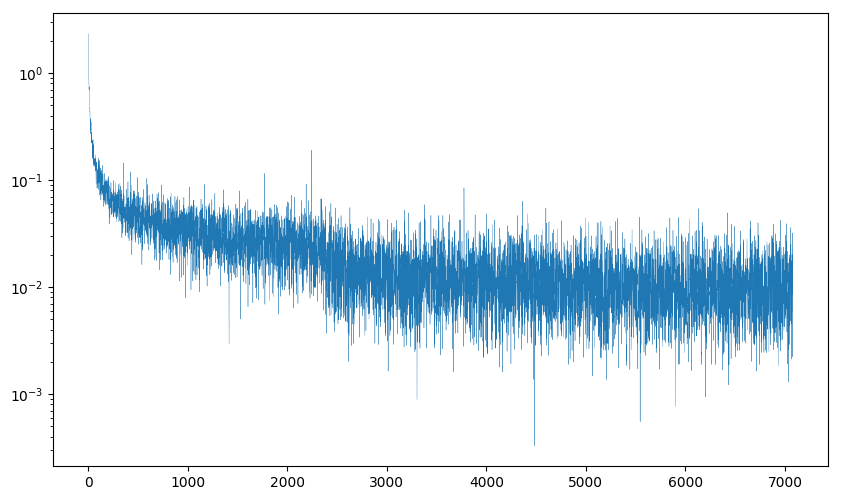

In [18]:
fig, (ax0) = plt.subplots(1,1, figsize=(10,6), dpi=100)

ax0.plot(np.average(np.vstack(all_losses),0), linewidth=0.25)
plt.yscale('log')

# Visualization Code

## Create a 2800 x 2800 tiled image from the 10,000 test images

In [0]:
def tile_digits(digits, outputs=None, shape='Square', train=False):
    ds = datasets.MNIST('../data', train=train, transform=transforms.Compose([
                           transforms.ToTensor()]))

    cmap = mpl.cm.jet
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, N=10)
    
    def get_img(idx):
        if idx >= len(digits) or idx < 0 or digits[idx] < -10:
            return np.zeros((28,28,3)).astype('uint8')
        
        idx = digits[idx]
        if idx < 0:
            clr = cmap(-idx-1)
            img = np.full((28,28,1), 255)
        else:
            clr = cmap(ds[idx][1])
            img = ds[idx][0].numpy().reshape(28,28)*255
            
        return np.dstack([(img*clr[c]).astype('uint8') for c in range(3)])

    def get_target(idx):
        if idx >= len(digits) or idx < 0 or digits[idx] < 0:
            return -1
        return ds[digits[idx]][1]

    def get_class(idx):
        if idx >= len(digits) or idx < 0 or digits[idx] < 0:
            return -1
        return outputs[digits[idx]].argmax(dim=0, keepdim=True).numpy().T[0]

    cnt = len(digits)
    if shape is 'Square':
        cols = np.ceil(np.sqrt(cnt)).astype('int64')
    elif shape is 'Horizontal':
        cols = cnt
    else:
        cols = 1

    img = np.vstack([np.hstack([get_img(off+col) for col in range(cols)]) for off in range(0, cnt, cols)])
    targets = np.vstack([np.hstack([get_target(off+col) for col in range(cols)]) for off in range(0, cnt, cols)])
    if outputs is None:
        return img, targets
    else:
        classes = np.vstack([np.hstack([get_class(off+col) for col in range(cols)]) for off in range(0, cnt, cols)])

    return img, targets, classes

In [0]:
tiled, target = tile_digits(range(10000))
imageio.imwrite(os.path.join(data_path, 'tiled.png'), tiled)

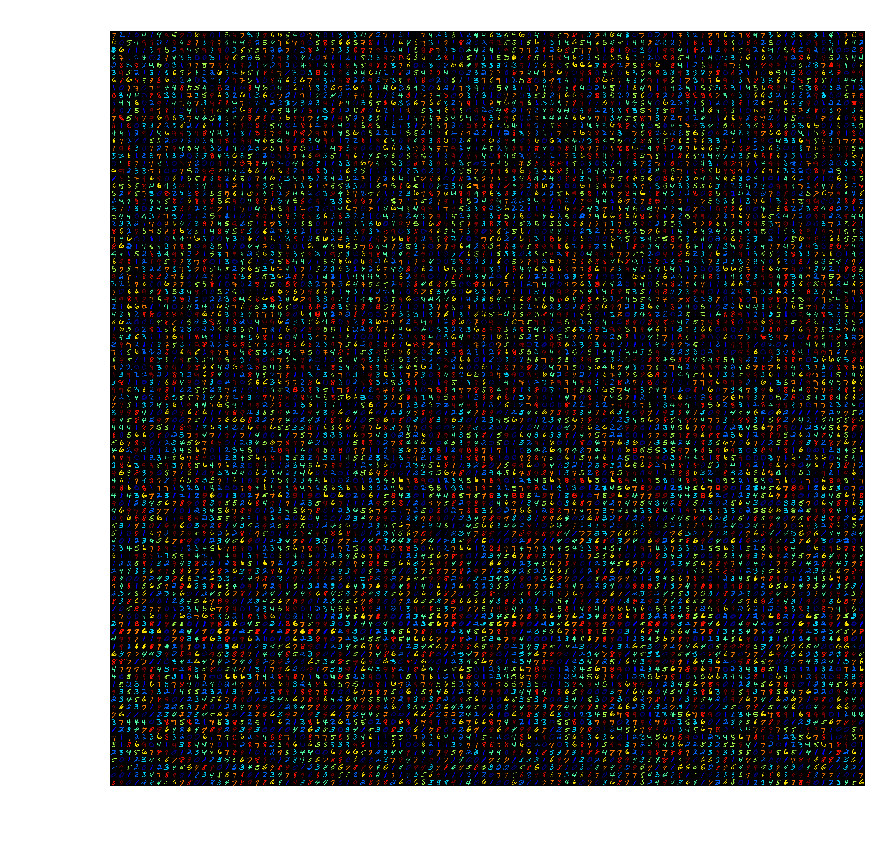

In [21]:
fig, ax=plt.subplots(figsize=(5,5), dpi=200)
ax.axis('off')
plt.imshow(tiled)
plt.show()

## Inspect Failures

In [0]:
failure_indices, output_all, target_all = optimizers[0].get_failures(test_loader)

In [23]:
target_failures = target_all[failure_indices]
failure_idx_by_digit = list(map(lambda digit: np.where(target_failures.eq(digit).to(torch.device("cpu")))[0], range(0,10)))

# Print sorted failures
sorted_failures = np.hstack(failure_idx_by_digit)
fail_img, targets, classes = tile_digits(failure_indices[sorted_failures], output_all.to(torch.device("cpu")))

print(len(failure_indices))
print('Classifications:\n', classes)
imageio.imwrite(os.path.join(data_path, 'sorted_failures.png'), fail_img)


39
Classifications:
 [[ 5  7  3  7  7  9  6]
 [ 7  3  0  7  7  1  5]
 [ 2  9  9  9  3  0  6]
 [ 4  8  1  1  1  2  8]
 [ 2  1  2  0  2  5  4]
 [ 4  4  4  3 -1 -1 -1]]


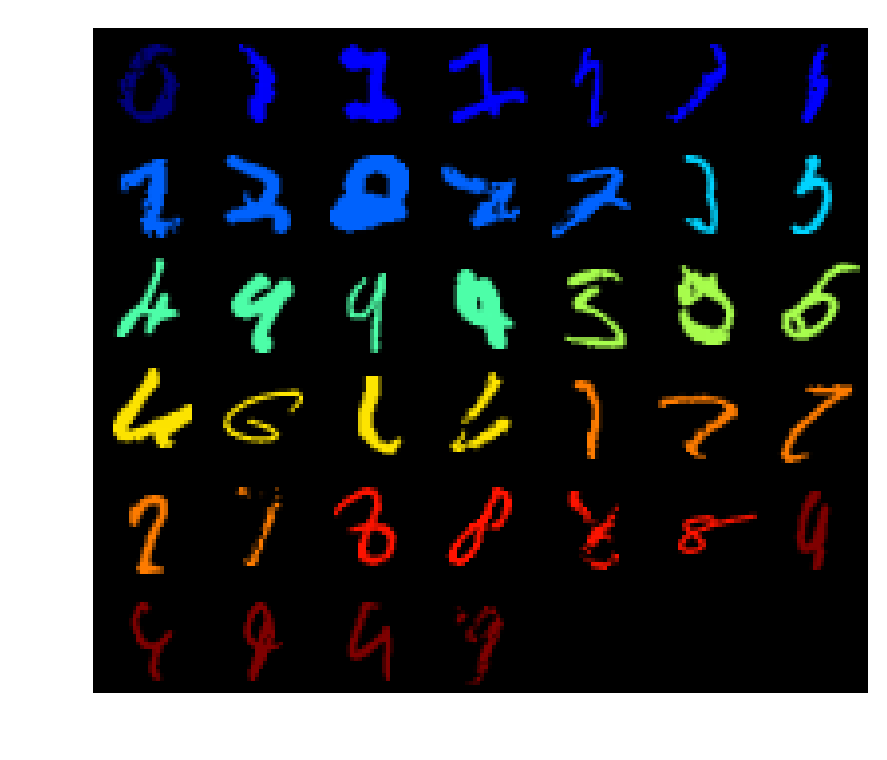

In [24]:
fig, ax=plt.subplots(figsize=(5,5), dpi=200)
ax.axis('off')
plt.imshow(fail_img)
plt.show()

## Plot t-SNE embedding of fc1 features
First extract the fc1 features for each test image and their ground truth values

In [0]:
epochs = optimizers[0].epoch
fc1 = []
target = []
epochs_list = range(epochs-3, epochs)
for epoch in epochs_list:
    optimizers[0].load_checkpoint(epoch+1)
    f, t = optimizers[0].get_fc1_features(test_loader)
    fc1.append(f)
    target.append(t)
    
fc1 = np.vstack(fc1)
target = np.hstack(target)

In [26]:
print(list(epochs_list))

[57, 58, 59]


Embed the 128 dimensional fc1 features in 2D space

In [0]:
X_embedded = TSNE(n_components=2).fit_transform(fc1)

Plot the 2D embedding, color-coded by the ground truth value

30000

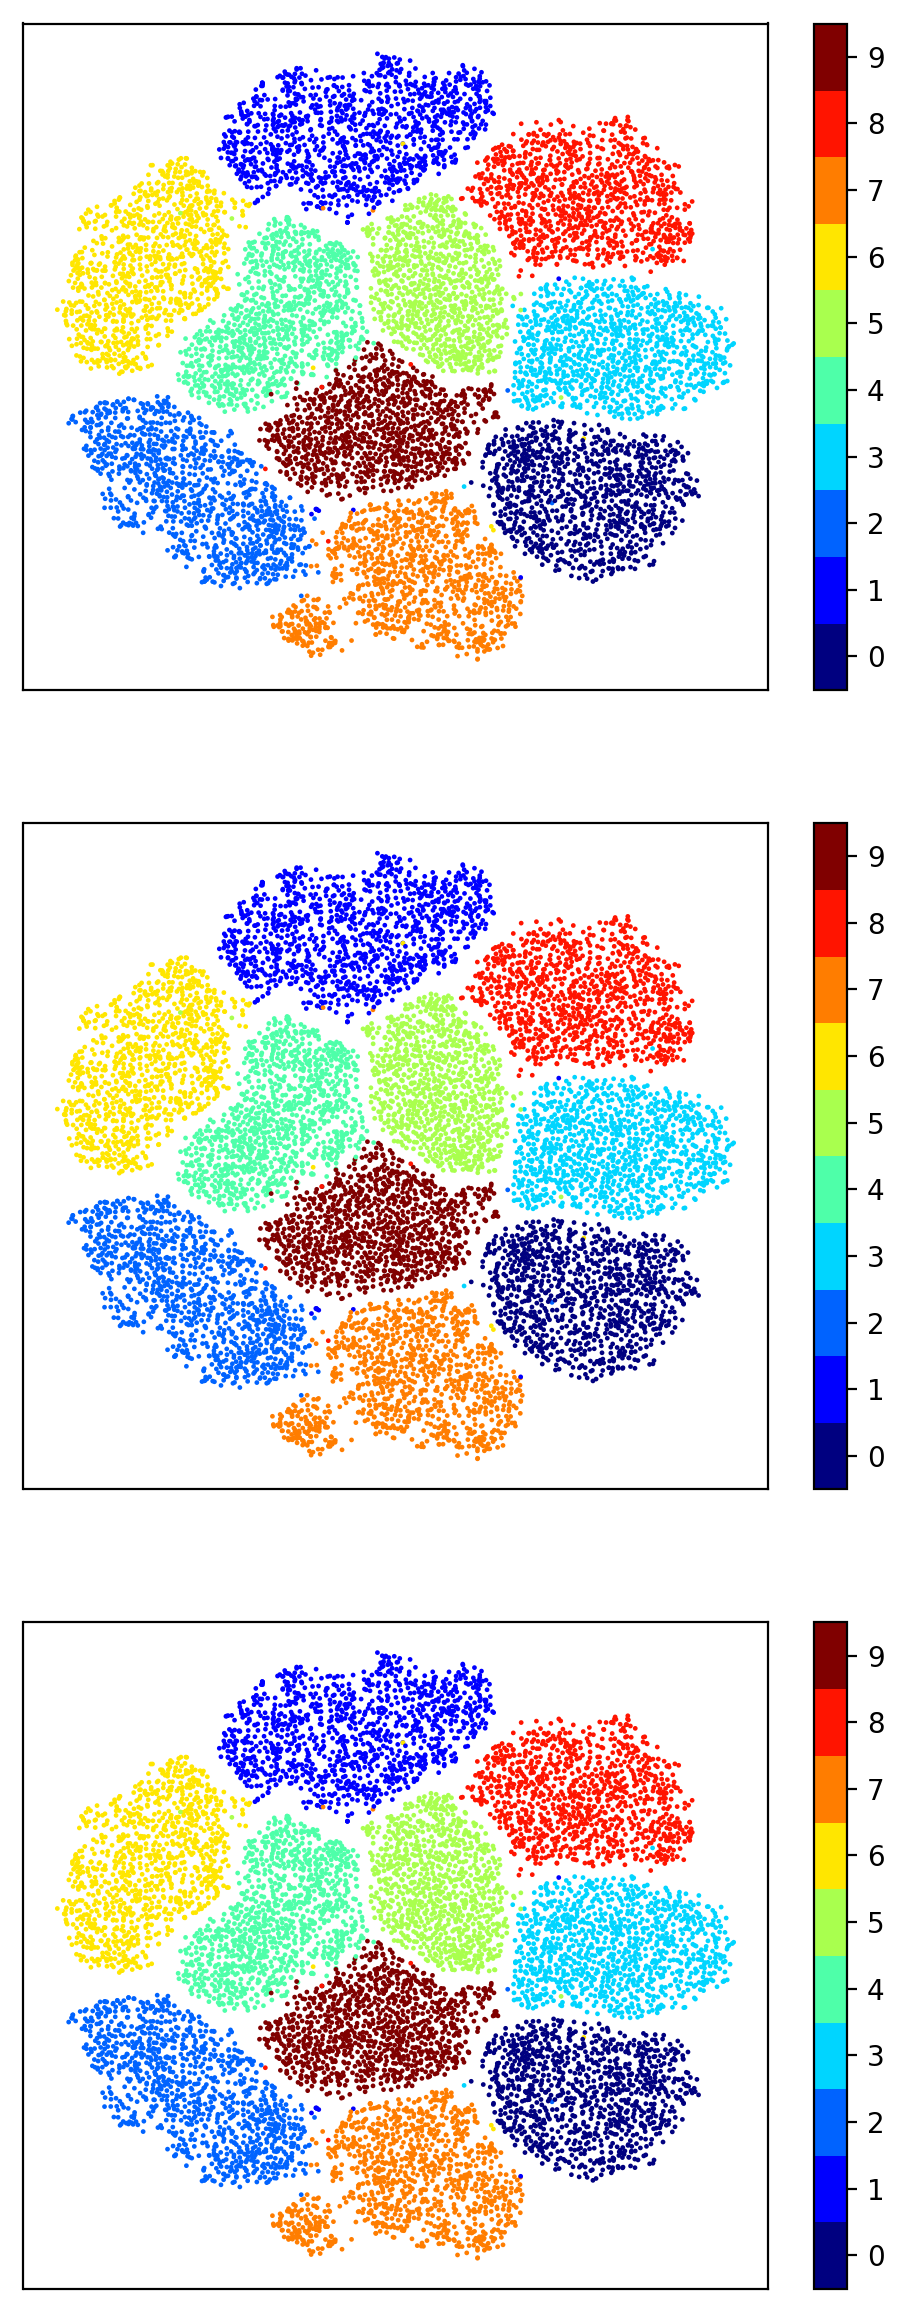

In [28]:
cmap = mpl.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, N=10)

#def onclick(event):
#    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
#          ('double' if event.dblclick else 'single', event.button,
#           event.x, event.y, event.xdata, event.ydata))

fig, ax = plt.subplots(len(epochs_list), 1, figsize=(6,len(epochs_list)*5), dpi=200)

#cid = fig.canvas.mpl_connect('button_release_event', onclick)
for i, epoch in enumerate(epochs_list):
    test_count = len(test_loader.dataset)
    idx = range(test_count*i, test_count*(i+1))
    cs=ax[i].scatter(X_embedded[idx,0], X_embedded[idx,1],
                   norm=mpl.colors.Normalize(vmin=-0.5, vmax=9.5),
                   s=.5, c=target[idx], cmap=cmap)

    cb = plt.colorbar(cs, ax=ax[i])
    cb.set_ticks(np.arange(0,10))
    cb.set_ticklabels(np.arange(0, 10))

    ax[i].set_xticks([])
    ax[i].set_yticks([])


    #ax[1].set_xticks([])
    #ax[1].set_yticks([])


len(target)

### How about just 4, 7 and 9

In [0]:
lst = [4,7,9]
fc1_sub=fc1[np.isin(target,lst),:]
target_sub=target[np.isin(target,lst)]

In [0]:
X_embedded_sub = TSNE(n_components=2).fit_transform(fc1_sub)

9057

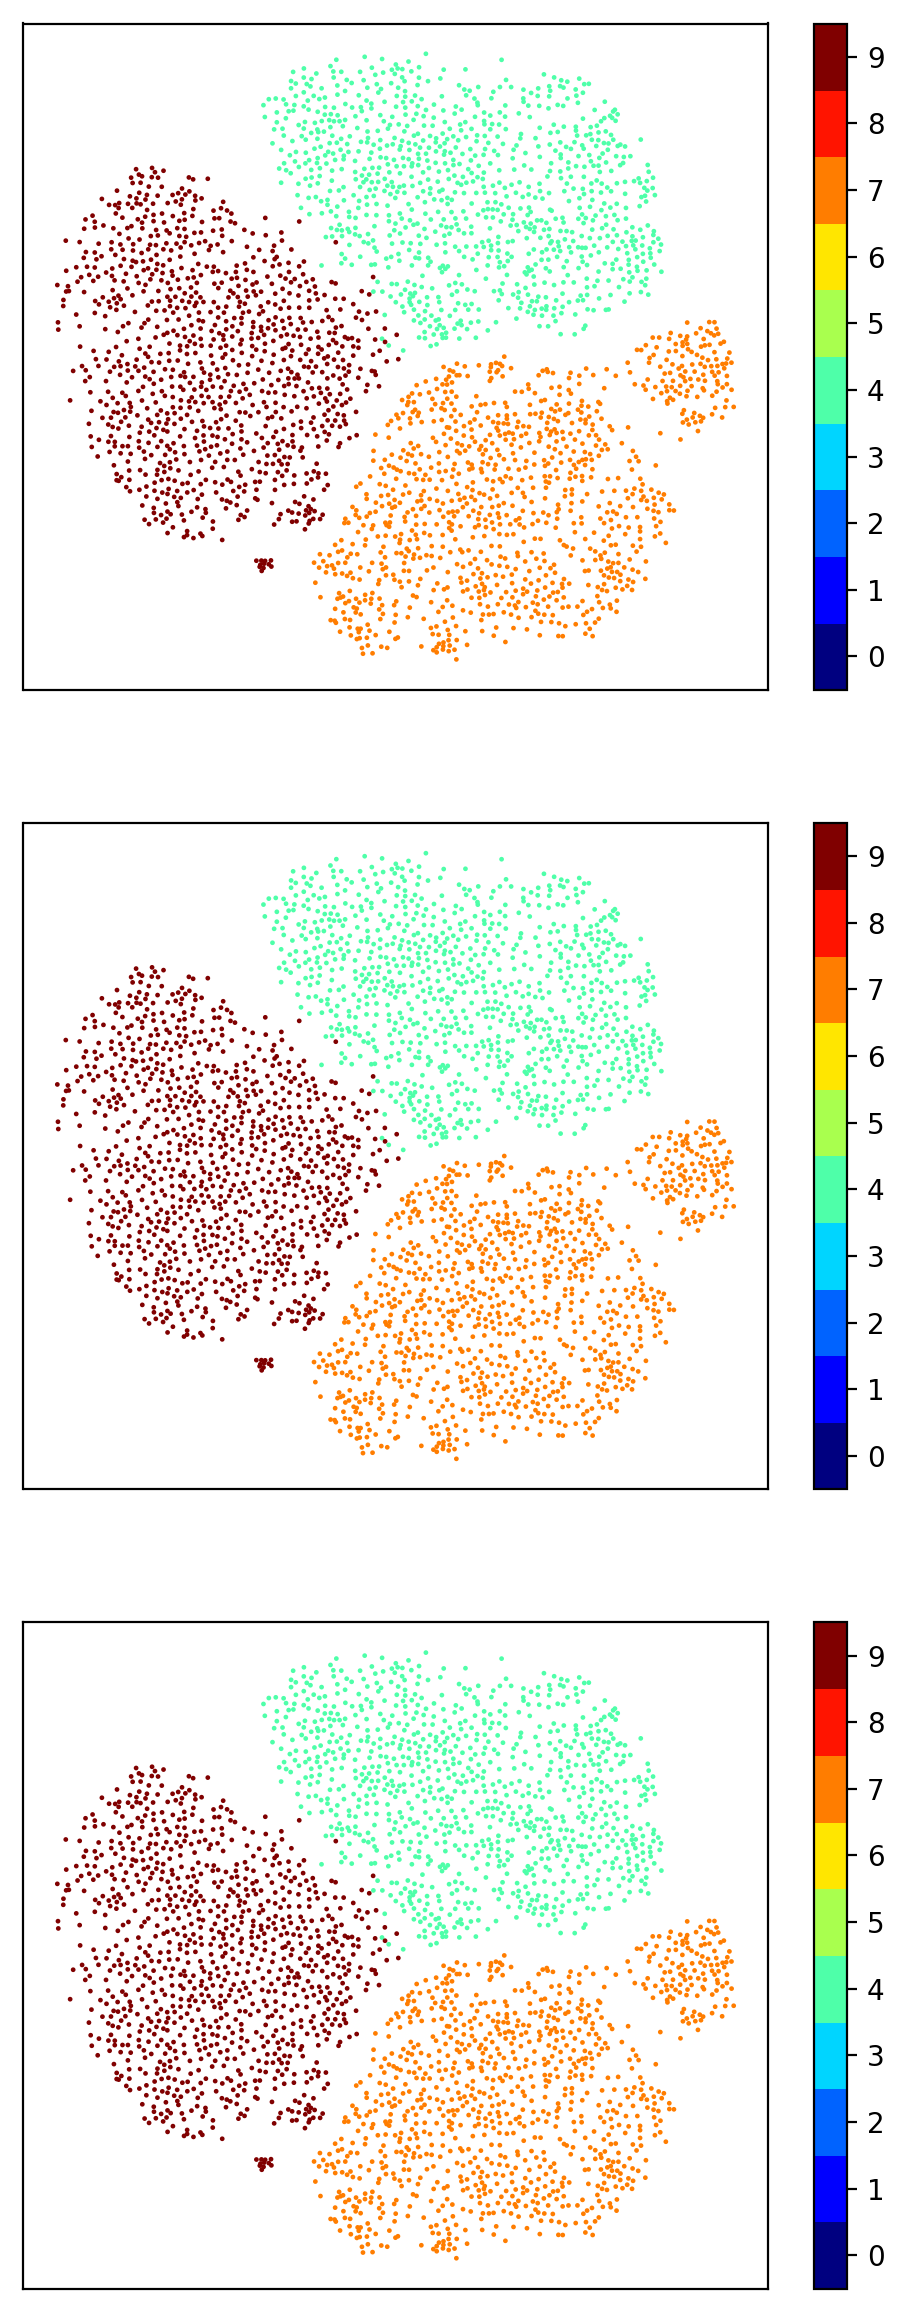

In [31]:
fig, ax = plt.subplots(len(epochs_list),1, figsize=(6,5*len(epochs_list)), dpi=200)

cmap = mpl.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, N=10)

for i, epoch in enumerate(epochs_list):
    test_count = len(target_sub)//len(epochs_list)
    idx = range(test_count*i, test_count*(i+1))

    cs=ax[i].scatter(X_embedded_sub[idx,0], X_embedded_sub[idx,1], s=.5, c=target_sub[idx], cmap=cmap, norm=mpl.colors.Normalize(vmin=-0.5, vmax=9.5))
    cb = plt.colorbar(cs, ax=ax[i])
    cb.set_ticks(np.arange(0,10))
    cb.set_ticklabels(np.arange(0, 10))

    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
len(target_sub)

## What are the Nearest Neighbors for Failures?

In [0]:
# Get a data loader with no augmentation
train_loader_fc1 = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=optimizers[0].batch_size, shuffle=False, **optimizers[0].kwargs)

train_fc1, train_target=optimizers[0].get_fc1_features(train_loader_fc1)

In [0]:
nbrs = NearestNeighbors(n_neighbors=16, algorithm='ball_tree').fit(train_fc1)
distances, indices = nbrs.kneighbors(fc1[failure_indices[sorted_failures],:])

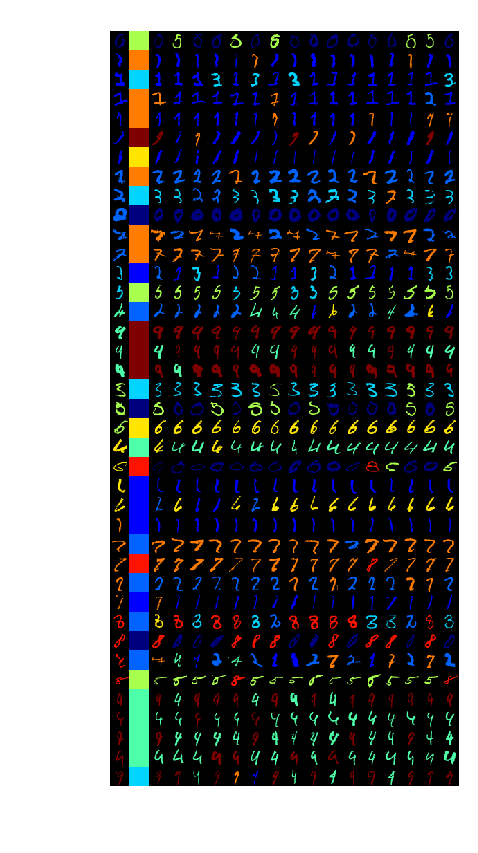

In [34]:
cnt = len(sorted_failures)

failure_classes = output_all[failure_indices[sorted_failures]].argmax(dim=1, keepdim=True) # get the index of the max log-probability

failure_img = tile_digits(failure_indices[sorted_failures], shape='Vertical')[0]
failure_classification_img = tile_digits((-failure_classes.to(torch.device("cpu")).numpy()-1).transpose()[0], shape='Vertical')[0]
neigh_img = np.vstack([tile_digits(indices[idx,:], shape='Horizontal', train=True)[0] for idx in range(cnt)])

imageio.imwrite(os.path.join(data_path, 'neighbors_train.png'), np.hstack([failure_img, failure_classification_img, neigh_img]))

fig, ax=plt.subplots(figsize=(5,5), dpi=200)
ax.axis('off')
ax.imshow(np.hstack([failure_img, failure_classification_img, neigh_img]))

plt.show()

## Plot Confusion Matrix
The confusion matrix plotting function was copied from [Yassine Ghouzam's great notebook](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6)

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

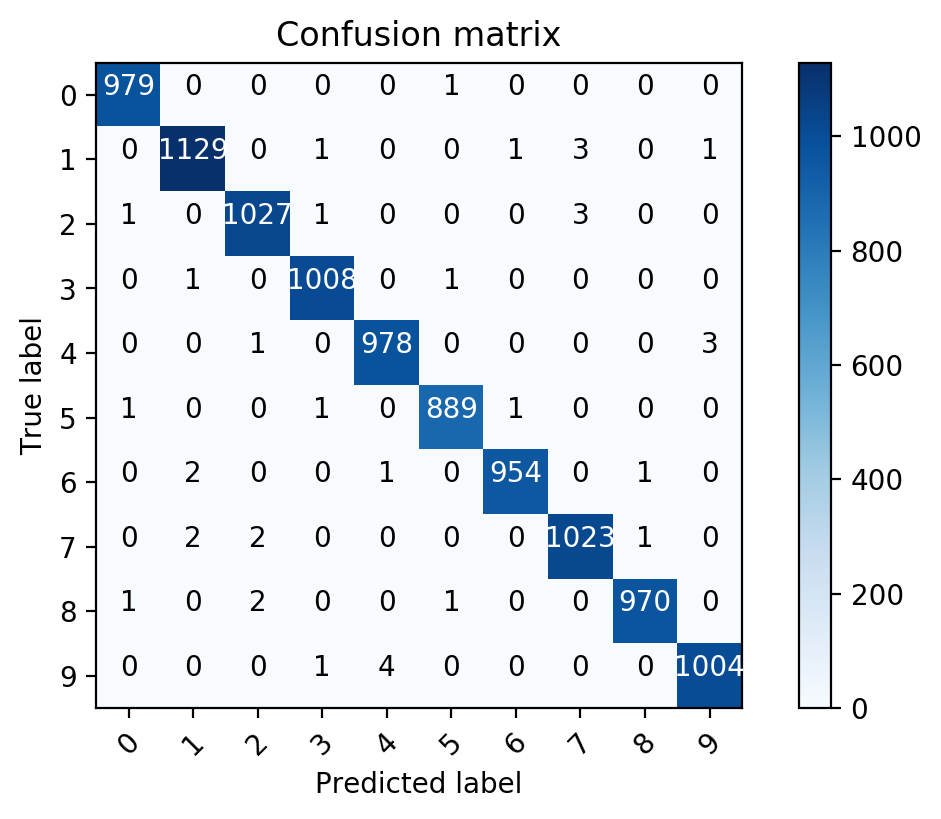

In [36]:
pred_all = output_all.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            
# compute the confusion matrix
confusion_mtx = confusion_matrix(target_all.to(torch.device("cpu")), pred_all.to(torch.device("cpu"))) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

## Look at weights/kernels

In [0]:
def plot_kernels(conv_layer):
    out_dim = conv_layer.size()[0]
    in_dim = conv_layer.size()[1]
    kw = conv_layer.size()[2]
    kh = conv_layer.size()[3]

    for row in range(0,out_dim):
        fig, ax = plt.subplots(1, in_dim)
        for col in range(0,in_dim):
            if in_dim>1:
                col_ax = ax[col]
            else:
                col_ax = ax
            col_ax.imshow(conv_layer[row][col].numpy(), cmap='binary')
            col_ax.axis('off')
        plt.show()

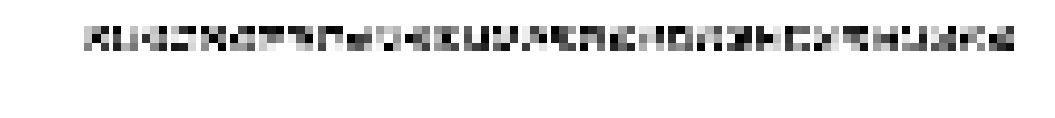

In [38]:
plot_kernels(optimizers[0].model.state_dict()['conv1.weight'].permute(1,0,2,3).to(torch.device("cpu")))

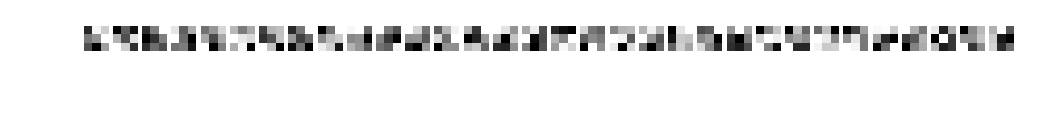

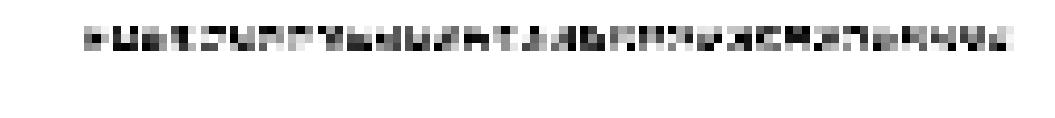

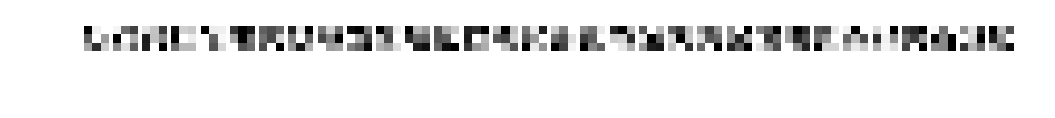

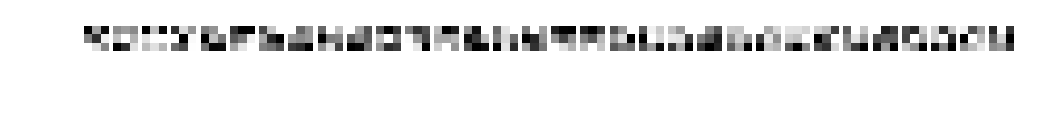

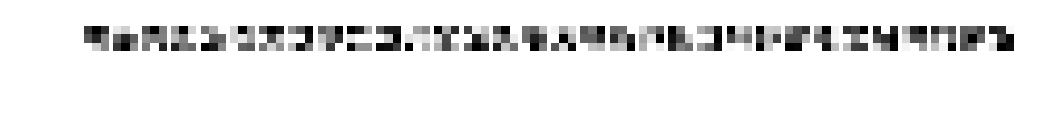

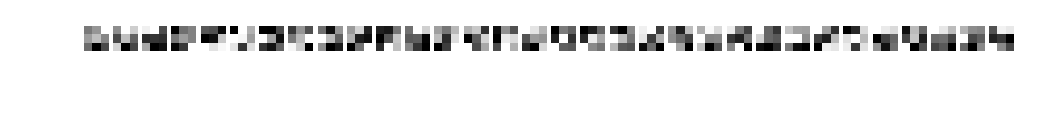

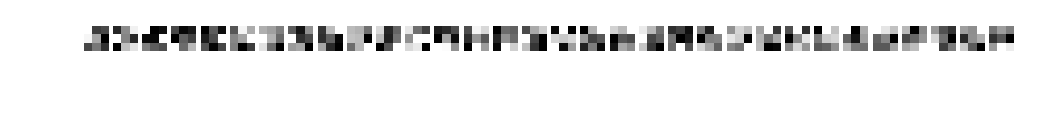

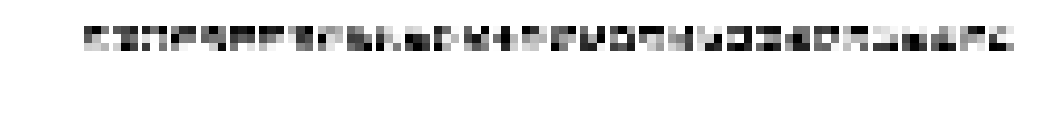

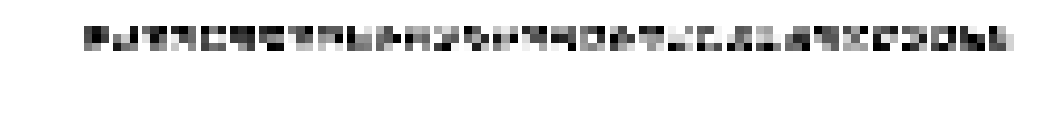

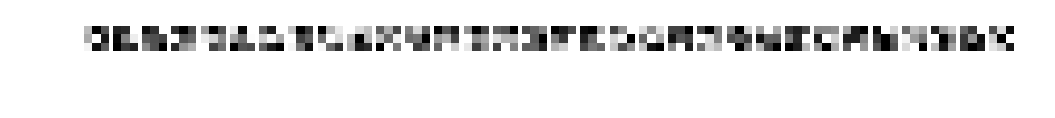

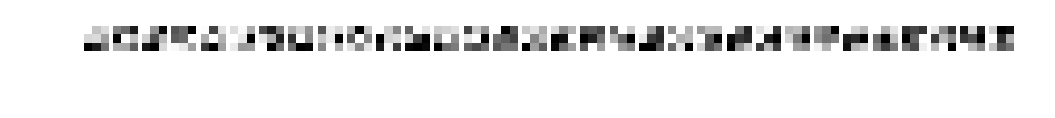

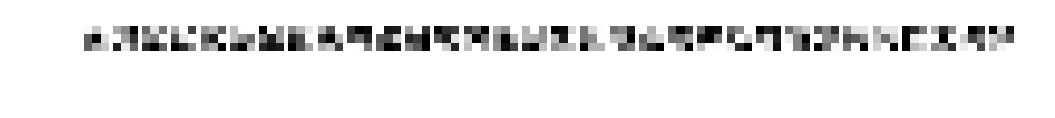

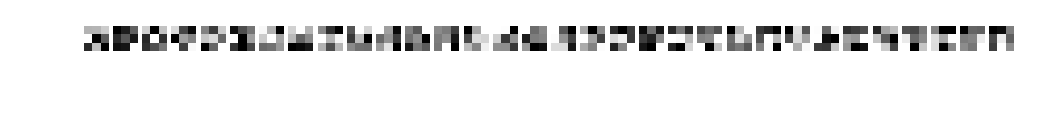

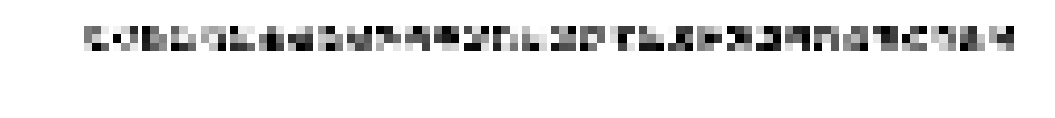

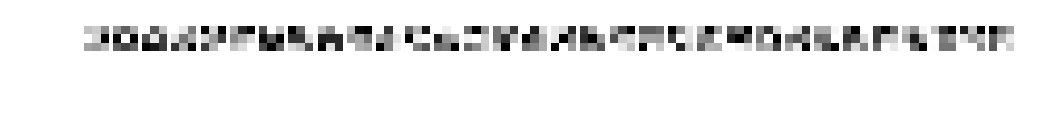

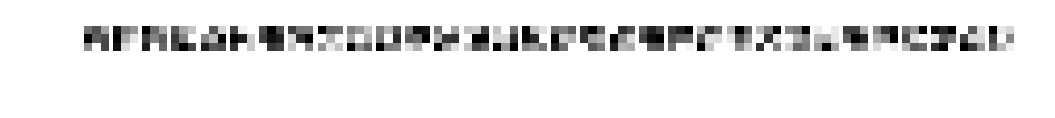

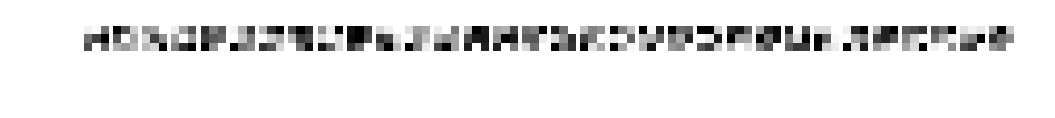

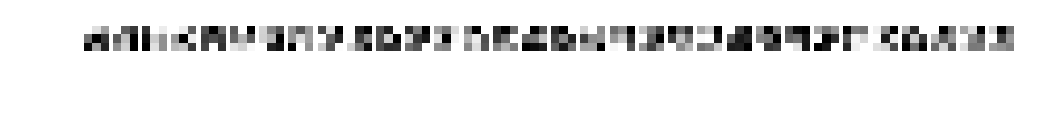

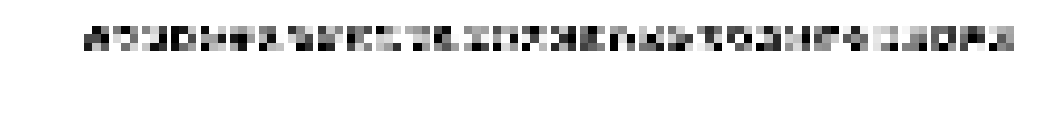

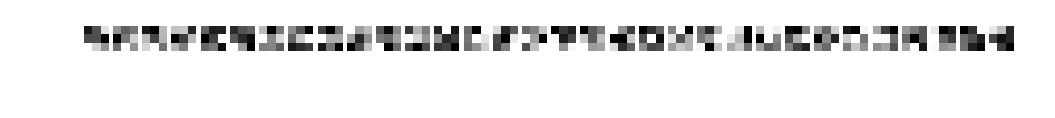

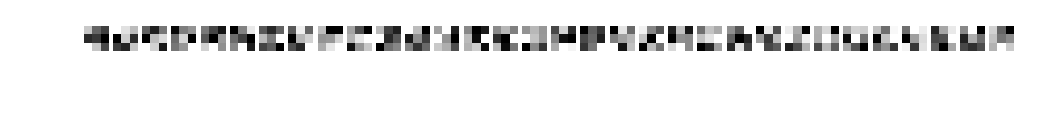

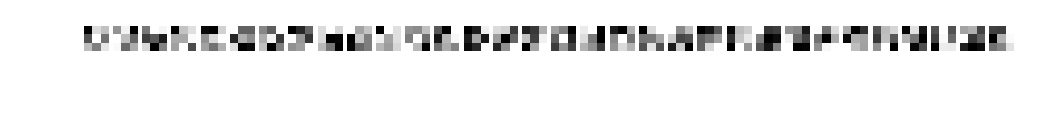

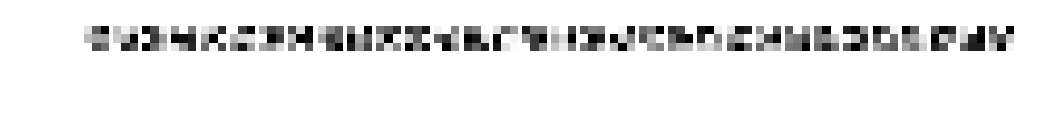

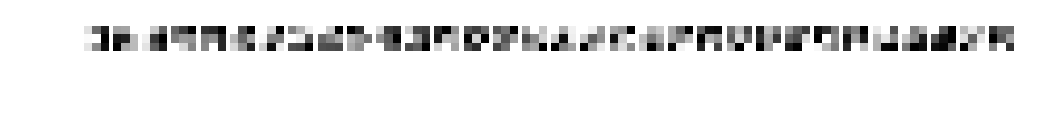

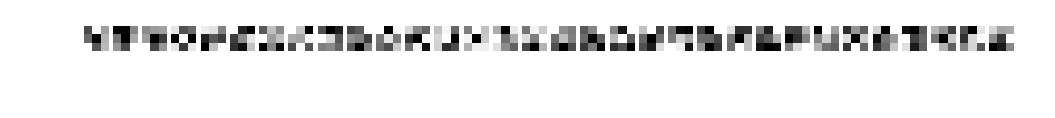

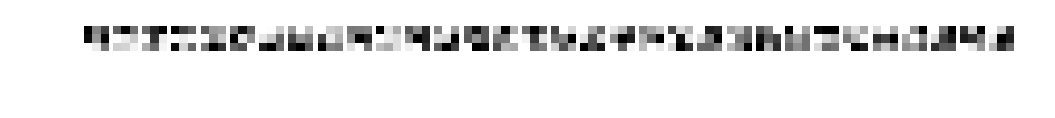

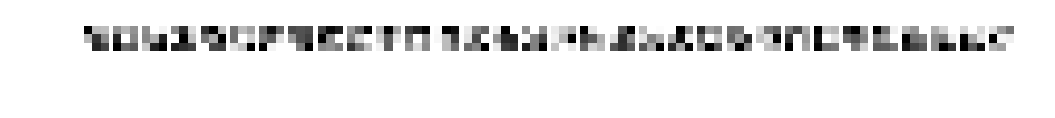

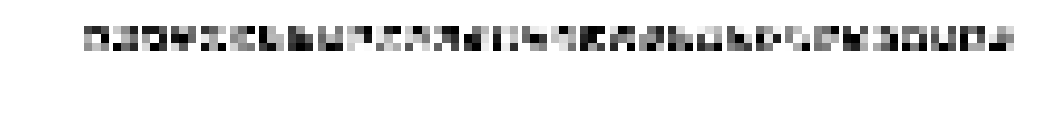

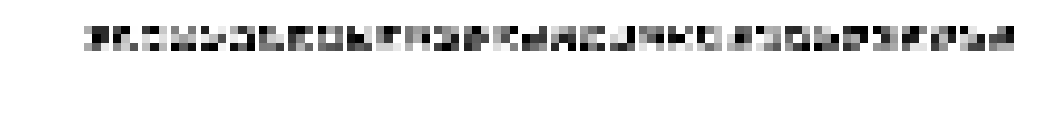

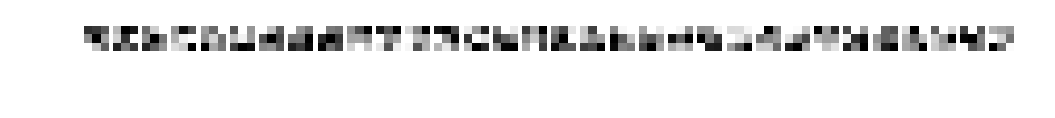

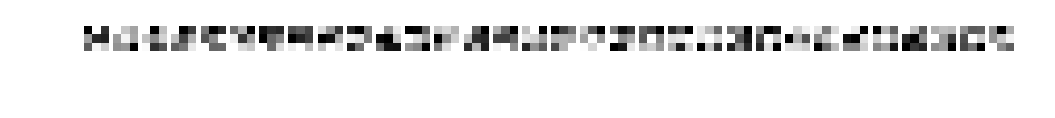

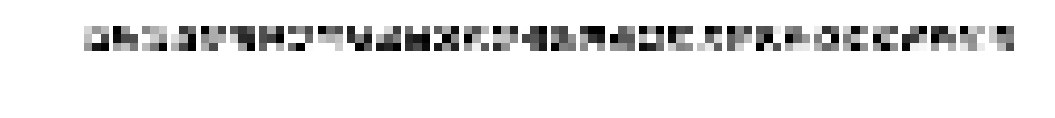

In [39]:
plot_kernels(optimizers[0].model.state_dict()['conv2.weight'].to(torch.device("cpu")))